In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import scipy.io

import models.model_2d as mod
import forward_model as fm
import utils as ut
import cv2
import io
import json
from os import path
import glob
import imageio
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
mpl.rc('image', cmap='inferno')

import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/dshteinbok/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
!gpustat

/bin/bash: /home/dshteinbok/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: gpustat: command not found


In [5]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

os.environ["CUDA_VISIBLE_DEVICES"]="0" 

## Load in saved models

In [6]:
registered_psfs_path = '../data/multiWienerPSFStack_40z_aligned.mat'
psfs = scipy.io.loadmat(registered_psfs_path)
psfs=psfs['multiWienerPSFStack_40z']
psf=psfs[:,:,0,0]
psf=psf/np.max(psf)
psfs=psfs[:,:,:,0]
psfs=psfs/np.max(psfs)
Ks =np.ones((1,1,9))
K=1

In [7]:
model1 =mod.UNet(486, 648, 
                         encoding_cs=[24, 64, 128, 256, 512, 1024],
                         center_cs=1024,
                         decoding_cs=[512, 256, 128, 64, 24, 24],
                         skip_connections=[True, True, True, True, True, False])
model3 =mod.UNet_multiwiener_resize(486, 648, psfs, Ks, 
                         encoding_cs=[24, 64, 128, 256, 512, 1024],
                         center_cs=1024,
                         decoding_cs=[512, 256, 128, 64, 24, 24],
                         skip_connections=[True, True, True, True, True, False])
model2 = mod.UNet_wiener(486, 648, psf, K, 
                         encoding_cs=[24, 64, 128, 256, 512, 1024],
                         center_cs=1024,
                         decoding_cs=[512, 256, 128, 64, 24, 24],
                         skip_connections=[True, True, True, True, True, False])

2022-09-26 16:05:51.404219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-26 16:05:51.413782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-26 16:05:51.414067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-26 16:05:51.416779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [8]:
model1.load_weights('./saved_models/unet')
model2.load_weights('./saved_models/unetwiener')
model3.load_weights('./saved_models/multiwiener')

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./saved_models/unet

## Load in real data

In [7]:
restarget=scipy.io.loadmat('../data/real_data/resTargetZ_1.mat')
restarget=restarget['b']


measurement shape: (486, 648)


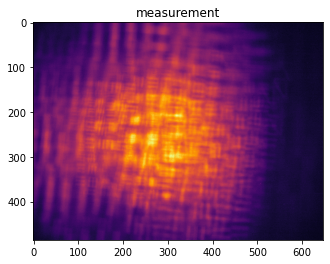

In [8]:
plt.imshow(restarget);
plt.title('measurement');
print('measurement shape:', restarget.shape)

## deconvolve 

In [9]:
recon1=model1.predict(restarget.reshape((1,486, 648,1)))
recon2=model2.predict(restarget.reshape((1,486, 648,1)))
recon3=model3.predict(restarget.reshape((1,486, 648,1)))


2022-02-03 09:12:58.313308: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-02-03 09:13:03.265239: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-02-03 09:13:06.621156: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10


In [10]:
recon_titles = ['Unet', 'WienerNet', 'MultiWienerNet (Ours)']
recons_np = [recon1[0], recon2[0], recon3[0]]

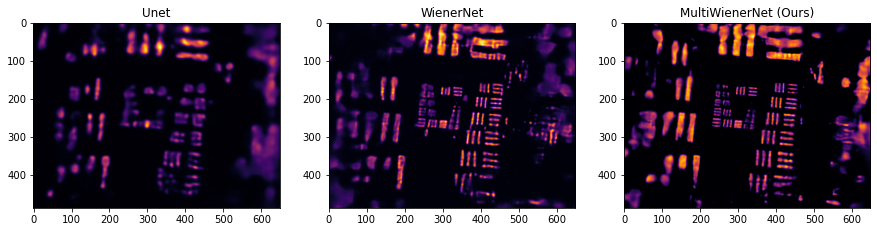

In [11]:
f, ax = plt.subplots(1, 3, figsize=(15,15))
for i in range(0,len(recons_np)):
    ax[i].imshow((recons_np[i]))
    ax[i].set_title(recon_titles[i])
    


## simulate data and deconvolve it

object shape: (486, 648)


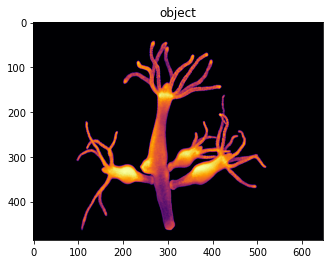

In [12]:
im_in=imageio.imread('../data/hydra3.jpg')
im_in=np.sum(im_in,-1)/3
im=cv2.resize(im_in,(648,486))

plt.imshow(im);
plt.title('object');
print('object shape:', im.shape)

In [13]:
# load forward model weights (these are extracted from the measured PSFs using the SVD model)
H,weights,crop_indices=fm.load_weights() # H and weights are extracted from SVD of the PSFS
                                            # rcL, rcU,ccL, ccU: crop indices used to crop the image to the correct size. 

In [14]:
# simulate data
sim=fm.sim_data(im,H,weights,crop_indices)

measurement shape: (486, 648)


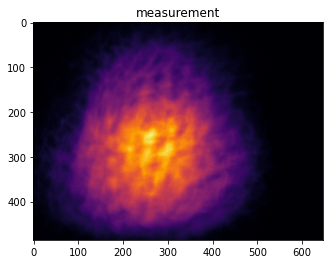

In [15]:
plt.imshow(sim);
plt.title('measurement');
print('measurement shape:', sim.shape)

In [16]:
recon1=model1.predict(sim.reshape((1,486, 648,1)))
recon2=model2.predict(sim.reshape((1,486, 648,1)))
recon3=model3.predict(sim.reshape((1,486, 648,1)))


In [17]:
recon_titles = ['Unet', 'WienerNet', 'MultiWienerNet (Ours)']
recons_np = [recon1[0], recon2[0], recon3[0]]

Unet :  PSNR:  15.67
WienerNet :  PSNR:  18.03
MultiWienerNet (Ours) :  PSNR:  23.22


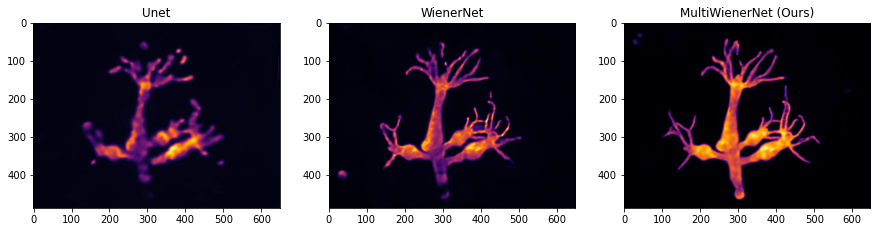

In [18]:
gt_np=im/255.
f, ax = plt.subplots(1, 3, figsize=(15,15))
for i in range(0,len(recons_np)):
    ax[i].imshow((recons_np[i]))
    ax[i].set_title(recon_titles[i])
    
for i in range(0,len(recons_np)):
    print(recon_titles[i], ': ','PSNR: ', np.round(ut.calc_psnr(gt_np, recons_np[i]),2))

### Compare against spatially-varying FISTA

Text(0.5, 1.0, 'MultiWienerNet (Ours)')

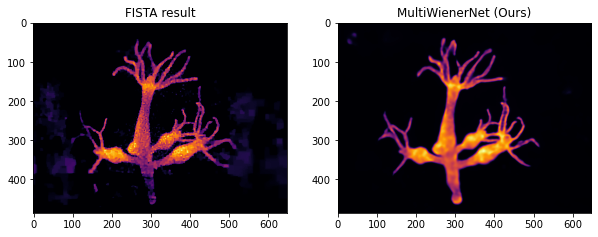

In [19]:
fista_recon=imageio.imread('../data/hydra_fista.png')
f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow((fista_recon))
ax[0].set_title('FISTA result')
ax[1].imshow((recons_np[-1]))
ax[1].set_title(recon_titles[-1])

## Inspect learned filters

In [20]:
learned_psfs=model3.trainable_variables[0].numpy()
learned_ks=model3.trainable_variables[1].numpy()

Text(0.5, 1.0, 'Learned filter')

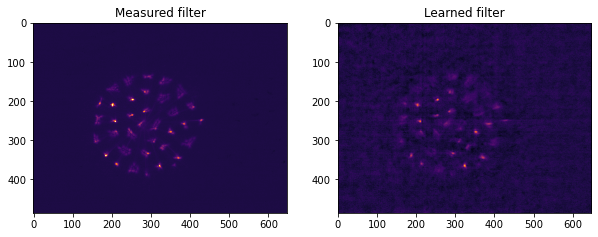

In [21]:
f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow((psfs[:,:,4]), vmax=0.4) # contrast stretched to show details
ax[0].set_title('Measured filter')
ax[1].imshow((learned_psfs[:,:,4]))
ax[1].set_title('Learned filter')

In [22]:
model_wiener_learned=mod.MultiWienerDeconvolution(learned_psfs,learned_ks)
model_wiener_measured=mod.MultiWienerDeconvolution(psfs,Ks)

In [23]:
# ignore the datatype warning
wienerstage_recon_learned=model_wiener_learned(restarget.reshape((1,486, 648,1)).astype('float32'))
wienerstage_recon_measured=model_wiener_measured(restarget.reshape((1,486, 648,1)).astype('float32'))

Text(0.5, 1.0, 'WienerDeconvStage w/ learned filter')

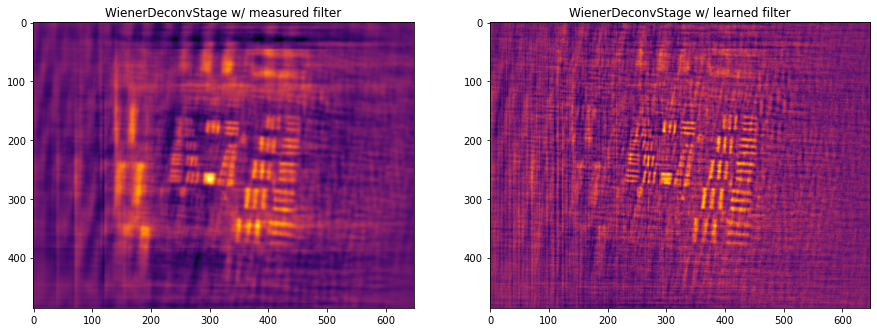

In [24]:
f, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow((wienerstage_recon_measured.numpy()[0,:,:,4])) 
ax[0].set_title('WienerDeconvStage w/ measured filter')
ax[1].imshow((wienerstage_recon_learned.numpy()[0,:,:,4]))
ax[1].set_title('WienerDeconvStage w/ learned filter')


Note how deconvolution with the learned filter yields sharper intermediate results. Zoom in on the middle of the resolution target